**Task 1:**

Read the code of the Ant Colony Optimization algorithm (ACO) to familiarize yourself with the methods and variables used. Complete the code by filling the methods marked with #TODO in classes *Problem* and *TSP*.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from collections import Counter

**Pheromone update:**

$$\tau _{xy}\leftarrow (1-\rho )\tau _{xy}+\sum _{k}\Delta \tau _{xy}^{k}$$

$$\Delta \tau _{xy}^{k}={\begin{cases}q/L_{k}&{\mbox{if ant }}k{\mbox{ uses curve }}xy{\mbox{ in its tour}}\\0&{\mbox{otherwise}}\end{cases}}$$

In [128]:
class Problem:
    name_to_id = {} # translates the name of an element of a solution to its ID (to be used in arrays)
    parts_phero = []  # the amount of pheromones on an element of a solution
    parts_phero_delta = [] # the amount of pheromones added to the element by the ants in a given iteration
    
    min_prob = True # is this a minimization problem?
    
    alpha = 1 # importance of the pheromone level
    beta = 1 # importance of the heuristic knowledge
    ro = 0.5 # pheromone evaporation coefficient
    q = 10 # multiplier of the pheromone deposit

    
    ### these methods MUST be implemented in the INHERITING class ###
    
    # initialization of the problem: initializing name_to_id, parts_phero, 
    # parts_phero_delta and other arrays used by the problem
    def __init__(self):
        pass

    # returns a random starting point for a new solution
    def initial_solution(self):
        return []
    
    # returns a list of all the elements making up a given solution
    def solution_parts(self, solution):
        return []

    # returns a value of the goal function for a given solution to the problem
    def solution_quality(self, solution):
        return 0
    
    # returns lists of the elements that can be added to the solution, 
    # and the probabilities of them being added
    def possible_choices(self, part_solution):
        return [], []
    
    
    ### these methods CAN be implemented in the INHERITING class ###
    
    # shows the given solution
    def display_solution(self, solution):
        pass
    
    # shows the current distribution of the pheromones
    def display_pheromones(self):
        pass

    
    #### these methods MUST be implemented HERE ###
    def apply_pheromones(self, solution):
        # TODO add pheromones to parts_phero_delta
        # for all elements in the solution (self.solution_parts(solution))
        # remember to check min_prob!
        #print(solution)
        quality = self.solution_quality(solution)
        to_add = 1/quality if self.min_prob else quality
        for elem in self.solution_parts(solution):
            self.parts_phero_delta[elem] += self.q * quality

    def update_pheromones(self):
        # TODO update the array of pheromone levels parts_phero based on 
        # the parts_phero_delta from this iteration of the algorithm
        
        self.parts_phero = [self.parts_phero[i]*(1-self.ro) + self.parts_phero_delta[i] for i in range(len(self.parts_phero))]
        # TODO prepare parts_phero_delta for the next iteration
        self.parts_phero_delta = [0 for i in range(len(self.parts_phero))]
        #print(sum(self.parts_phero))
    def construction_step(self, part_solution):
        #print(part_solution)
        choices, probs = self.possible_choices(part_solution)
        # TODO select and add a new element to the solution
        part_solution += random.choices(population = choices, weights = probs)
        
        return part_solution

    def walk(self):
        solution = self.initial_solution()
        while len(self.possible_choices(solution)[0]) > 0:
            solution = self.construction_step(solution)
        #print(solution)
        return solution
    
    def reset_pheromones(self):
        self.parts_phero = [1 for i in range(len(self.parts_phero))]
        self.parts_phero_delta = [0 for i in range(len(self.parts_phero))]
    
    def solve(self, iterations = 1000, ants = 100, alpha = 1, beta = 1, ro = 0.5, q = 100, display_period = 100):
        self.alpha = alpha
        self.beta = beta
        self.ro = ro
        self.q = q
        
        best_sol = None
        best_sol_q = (float('inf') if self.min_prob else float('-inf'))
        for j in range(iterations):
            for i in range(ants):
                sol = self.walk() # construct a single solution
                self.apply_pheromones(sol) # update parts_phero_delta for this solution
                sol_q = self.solution_quality(sol)
                if (self.min_prob and sol_q < best_sol_q) or (not self.min_prob and sol_q > best_sol_q):
                    best_sol = sol
                    best_sol_q = sol_q
            self.update_pheromones() # update parts_phero for this iteration
            
            if j%display_period == 0:
                self.display_pheromones()
                self.display_solution(best_sol)
                print(best_sol, best_sol_q)
                
        return best_sol, best_sol_q

**Edge selection:**

$$p_{xy}^{k}={\frac {(\tau _{xy}^{\alpha })(\eta _{xy}^{\beta })}{\sum _{z\in \mathrm {allowed} _{x}}(\tau _{xz}^{\alpha })(\eta _{xz}^{\beta })}}$$

Remember: the solution is an array of cities, but the pheromones are being put on the edges between cities

In [129]:
class TSP(Problem):
    cities = []
    distance = []
    coords = {}

    def dist(self, x1, y1, x2, y2):
        return ((x1-x2)**2+(y1-y2)**2)**(1/2)

    def __init__(self):
        super().__init__()
        self.cities.extend(["Poznan", "Wroclaw", "Krakow", "Warszawa", "Gdansk", "Katowice", "Lodz",
                       "Bialystok", "Rzeszow", "Szczecin", "Lublin", "Olsztyn", "Kielce", "Gdynia", "Bydgoszcz", "Zakopane"])
        self.coords = {
            "Poznan": (52.409538, 16.931992),
            "Wroclaw": (51.107883, 17.038538),
            "Krakow": (50.049683, 19.944544),
            "Warszawa": (52.237049, 21.017532),
            "Gdansk": (54.372158, 18.638306),
            "Katowice": (50.270908, 19.039993),
            "Lodz": (51.759445, 19.457216),
            "Bialystok": (53.13333, 23.16433),
            "Rzeszow": (50.041187, 21.999121),
            "Szczecin": (53.42894, 14.55302),
            "Lublin": (51.25, 22.56667),
            "Olsztyn": (53.77995, 20.49416),
            "Kielce": (50.87033, 20.62752),
            "Gdynia": (54.51889, 18.53188),
            "Bydgoszcz": (53.1235, 18.00762),
            "Zakopane": (49.29899, 19.94885)
        }

        id = 0
        for c1 in self.cities:
            for c2 in self.cities:
                self.name_to_id[c1+"-"+c2] = id
                self.parts_phero.append(1)
                self.parts_phero_delta.append(0)
                self.distance.append(self.dist(self.coords[c1][0], self.coords[c1][1],
                                               self.coords[c2][0], self.coords[c2][1]))
                id += 1
        #print(self.distance)
    def possible_choices(self, part_solution):
        # TODO
        # choices - an array of the vetrices that can be added to the solution
        # probs - an array of probabilities of adding these solutions
        choices = [city for city in self.cities if city not in part_solution]
        last_node = part_solution[-1]
        possible_edges = [last_node+"-"+city for city in choices]
        #for edge in possible_edges:
           # print(edge)
            #print(self.distance[self.name_to_id[edge]])
        heuristic_info = [(1/self.distance[self.name_to_id[edge]]) ** self.beta for edge in possible_edges]
        pheromone_strength = [self.parts_phero[self.name_to_id[edge]] ** self.alpha for edge in possible_edges]
        phero_heuristic = [pheromone_strength[i] * heuristic_info[i] for i in range(len(possible_edges))]
        sum_phero_heuristic = sum(phero_heuristic)
        probs = [phero_heuristic[i]/sum_phero_heuristic for i in range(len(possible_edges))]
        
        return choices, probs
 
    def solution_quality(self, solution):
        # TODO
        # dist_sum - the length of the route in the solution
        edges = self.solution_parts(solution)
        
        dist_sum = sum([self.distance[edge] for edge in edges])
        
        return dist_sum
    
    def solution_parts(self, solution):
        # TODO
        # parts - a list of IDs of the edges in the solution
        #print(solution)
        if len(solution) > 1:
            parts = [self.name_to_id[solution[i-1]+"-"+solution[i]] for i in range(len(solution))]
        else:
            parts = []
        return parts

    def initial_solution(self):
        # TODO
        # init_sol - a random starting point for a new solution (the starting city)
        init_sol = [random.choice(self.cities)]
        
        return init_sol
    
    ### DISPLAY (you don't have to read it) ###

    def force_aspect(self, ax,aspect=1):
        im = ax.get_images()
        extent =  im[0].get_extent()
        ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

    def display_pheromones(self):
        self.display_pheromones_param(True, [11.328361, 27.045778], [49.0025, 54.835778])
        
    def display_pheromones_param(self, show_map, xlim, ylim):
        fig, ax = plt.subplots(figsize=(8, 8))

        if show_map:
            datafile = 'polska.png'
            img = mpimg.imread(datafile)
            plt.imshow(img, zorder=0, extent=[14.245, 24.129139, 49.0025, 54.835778])

        
        for c1 in self.cities:
            for c2 in self.cities:
                x = [self.coords[c1][1], self.coords[c2][1]]
                y = [self.coords[c1][0], self.coords[c2][0]]
                #print(x)
                line, = ax.plot(x, y, 'ro-', 
                                linewidth=3*self.parts_phero[self.name_to_id[c1+"-"+c2]]/max(self.parts_phero))

        if show_map:
            plt.xlabel('Długosc geograficzna')
            plt.ylabel('Szerokosc geograficzna')
            self.force_aspect(ax)
            
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.show()
        
        
    def display_solution(self, solution):
        self.display_solution_param(solution, True, [11.328361, 27.045778], [49.0025, 54.835778])
        
    def display_solution_param(self, solution, show_map, xlim, ylim):
        fig, ax = plt.subplots(figsize=(8, 8))
        
        if show_map:
            datafile = 'polska.png'
            img = mpimg.imread(datafile)
            plt.imshow(img, zorder=0, extent=[14.245, 24.129139, 49.0025, 54.835778])

        x = [i[1] for i in [self.coords[c] for c in solution]]
        y = [i[0] for i in [self.coords[c] for c in solution]]
        x.append(x[0])
        y.append(y[0])
        line, = ax.plot(x, y, 'go-',linewidth=2)

        if show_map:
            plt.xlabel('Długosc geograficzna')
            plt.ylabel('Szerokosc geograficzna')
            self.force_aspect(ax)
            
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.show()

**Task 2:**

- Test if your implementation works correctly
- Observe how the distribution of pheromones changes in time
- Is the optimal route clearly visible in the distribution of pheromones? If not - why?

340787.866425207


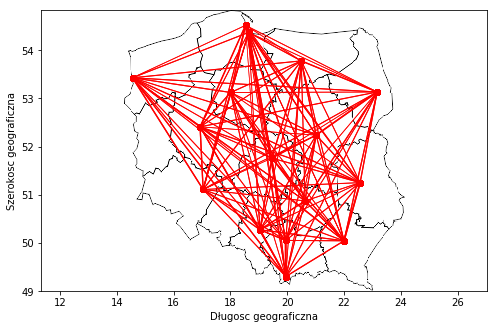

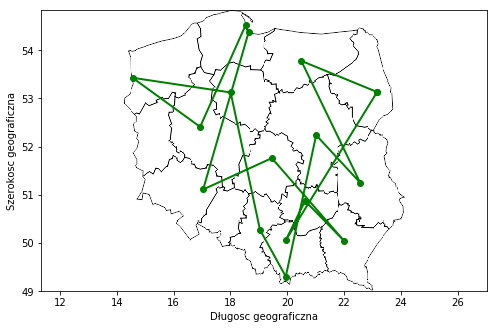

['Bialystok', 'Krakow', 'Kielce', 'Rzeszow', 'Lodz', 'Wroclaw', 'Gdansk', 'Gdynia', 'Poznan', 'Szczecin', 'Bydgoszcz', 'Katowice', 'Zakopane', 'Warszawa', 'Lublin', 'Olsztyn'] 40.56729020299445
312422.87317029433
290196.59852580365
273501.44961275125
259107.3858779386
249387.0195371553
240179.14458117445
233609.4117224994
229055.1062370141
225151.7839554092
219869.15396797154


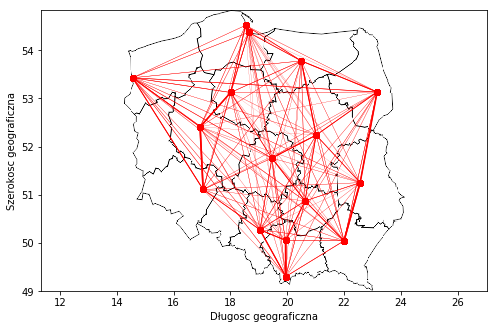

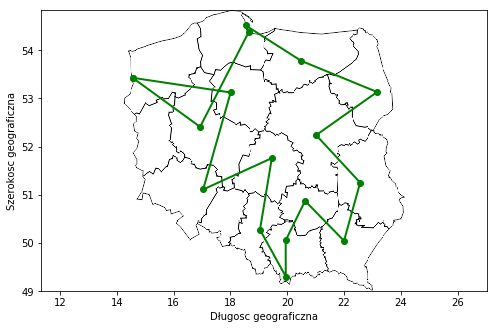

['Szczecin', 'Poznan', 'Gdansk', 'Gdynia', 'Olsztyn', 'Bialystok', 'Warszawa', 'Lublin', 'Rzeszow', 'Kielce', 'Krakow', 'Zakopane', 'Katowice', 'Lodz', 'Wroclaw', 'Bydgoszcz'] 30.220048050519154
216187.39991822175
214715.00929577203
213069.16615783353
211370.06579745386
210062.16188331836
209438.8223810063
208706.71978246717
207137.21978214115
206425.55000401608
205665.63717137958


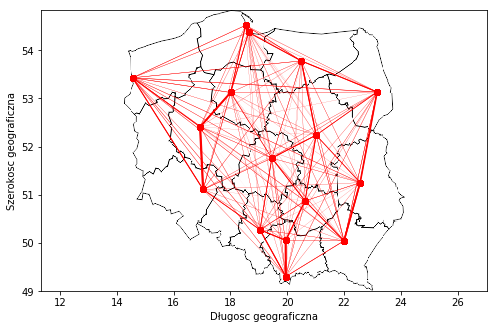

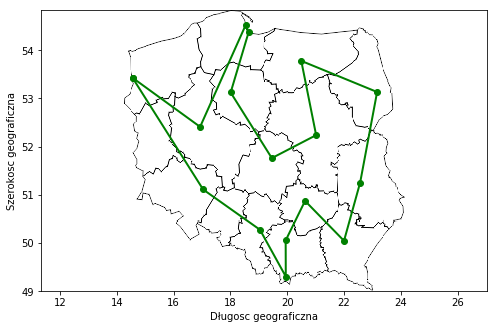

['Szczecin', 'Wroclaw', 'Katowice', 'Zakopane', 'Krakow', 'Kielce', 'Rzeszow', 'Lublin', 'Bialystok', 'Olsztyn', 'Warszawa', 'Lodz', 'Bydgoszcz', 'Gdansk', 'Gdynia', 'Poznan'] 28.447879498052778
205774.8058204376
205713.47255420074
205748.42331069798
205417.47451191593
205195.60485397608
204642.49929801252
204800.92741094076
204502.09290088675
205251.20409101326
205108.97945255978


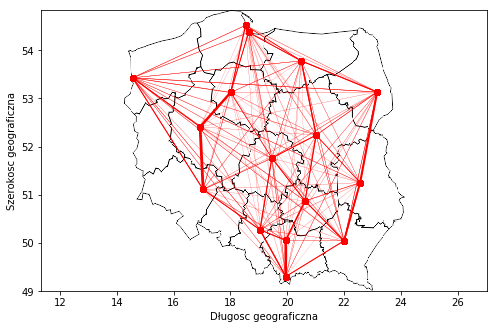

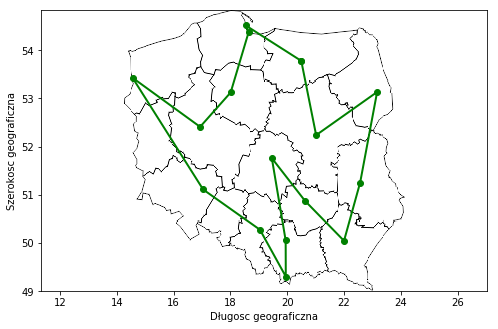

['Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Lodz', 'Krakow', 'Zakopane', 'Katowice', 'Wroclaw', 'Szczecin', 'Poznan', 'Bydgoszcz', 'Gdansk', 'Gdynia'] 27.3249580411615
204558.7543156164
204204.36762670608
203330.67383094452
203177.2811269885
202194.39802147087
201921.4097252831
202483.51069087005
202516.3746419275
201767.38581234709
200251.03625891963


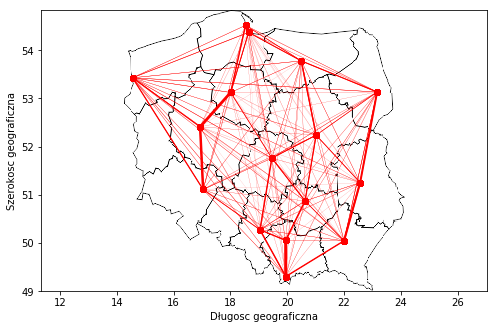

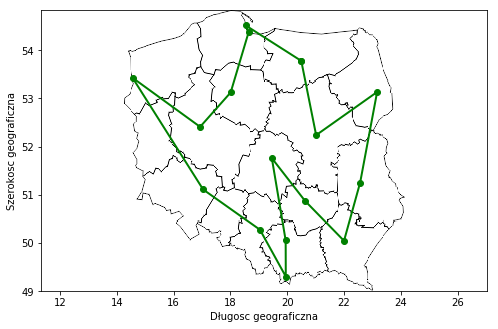

['Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Lodz', 'Krakow', 'Zakopane', 'Katowice', 'Wroclaw', 'Szczecin', 'Poznan', 'Bydgoszcz', 'Gdansk', 'Gdynia'] 27.3249580411615
200480.95223184826
199981.67843209943
199385.47198690704
198913.68246676904
197379.39065069938
197011.67822734264
196908.94975256763
198442.66229067274
198635.01128615346
198554.32263211126


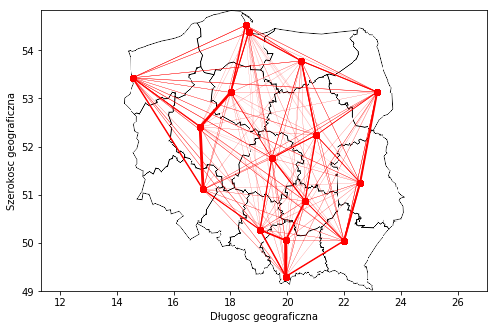

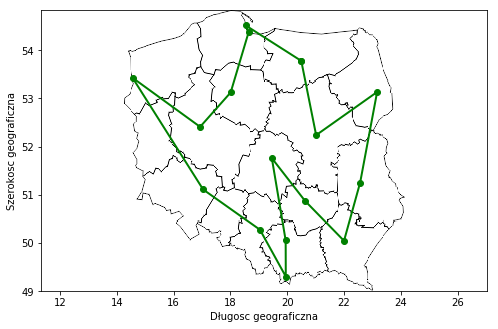

['Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Lodz', 'Krakow', 'Zakopane', 'Katowice', 'Wroclaw', 'Szczecin', 'Poznan', 'Bydgoszcz', 'Gdansk', 'Gdynia'] 27.3249580411615
198168.8505063324
198219.5383023258
197658.85637614143
197081.9456839682
197527.06298960905
198980.74093893415
197429.39663427265
197372.06768886786
196971.7445851771
196325.63957233823


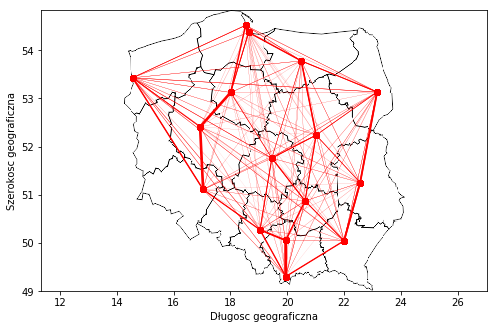

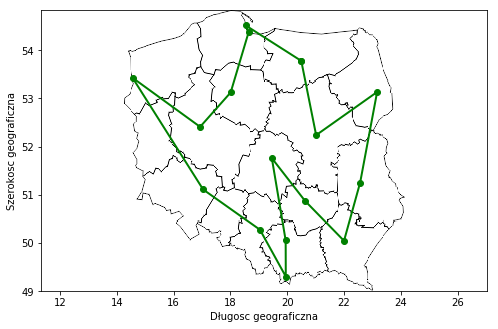

['Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Lodz', 'Krakow', 'Zakopane', 'Katowice', 'Wroclaw', 'Szczecin', 'Poznan', 'Bydgoszcz', 'Gdansk', 'Gdynia'] 27.3249580411615
196836.52533646562
196978.9930153902
196951.67950329362
196614.35967179236
196621.01986745553
196670.4099319386
198053.4923544472
198683.29299723465
198584.91966251648
198575.95487830156


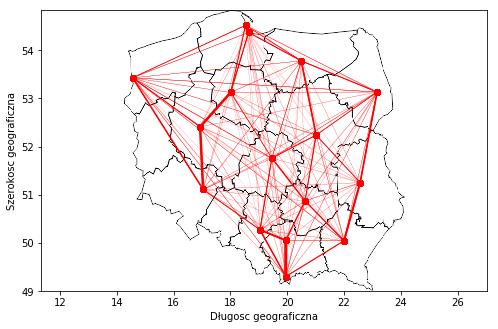

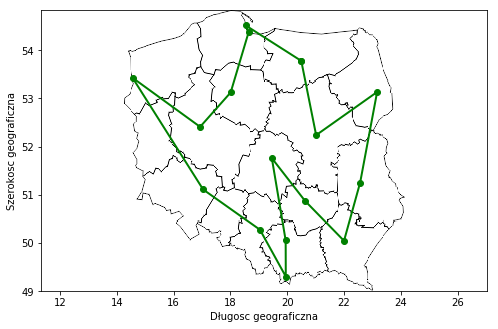

['Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Lodz', 'Krakow', 'Zakopane', 'Katowice', 'Wroclaw', 'Szczecin', 'Poznan', 'Bydgoszcz', 'Gdansk', 'Gdynia'] 27.3249580411615
198576.42428813336
198692.80136500055
199025.82882616413
199147.6678250727
198362.0332687396
199640.0481451532
200177.13514771813
198698.45600212688
198627.75400615102
198893.56211906992


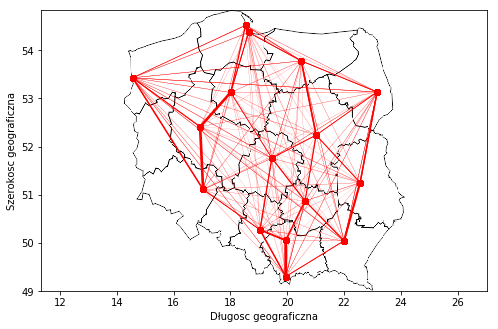

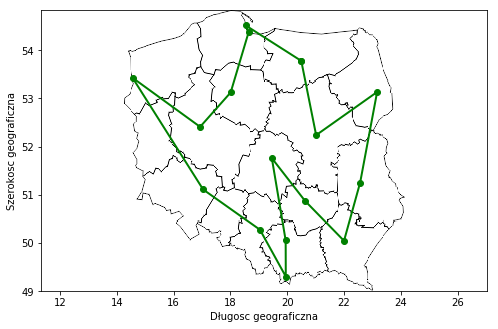

['Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Lodz', 'Krakow', 'Zakopane', 'Katowice', 'Wroclaw', 'Szczecin', 'Poznan', 'Bydgoszcz', 'Gdansk', 'Gdynia'] 27.3249580411615
200246.24134123165
200643.7386630385
200432.45544384638
200115.1711767886
200604.2778487074
200787.49086686387
201191.08461147768
200715.56348634788
200418.92371740635
200336.5643174005


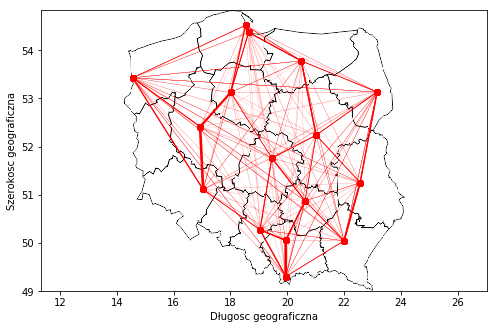

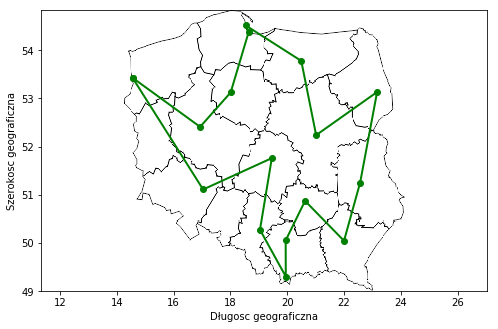

['Szczecin', 'Poznan', 'Bydgoszcz', 'Gdansk', 'Gdynia', 'Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Krakow', 'Zakopane', 'Katowice', 'Lodz', 'Wroclaw'] 27.026423832288263
200181.95854774656
199593.34192063854
199049.81253786373
198699.33590120828
198626.27652230987
198363.34065474078
198706.257473943
198501.69309331005
198417.34326618686


(['Szczecin',
  'Poznan',
  'Bydgoszcz',
  'Gdansk',
  'Gdynia',
  'Olsztyn',
  'Warszawa',
  'Bialystok',
  'Lublin',
  'Rzeszow',
  'Kielce',
  'Krakow',
  'Zakopane',
  'Katowice',
  'Lodz',
  'Wroclaw'],
 27.026423832288263)

In [116]:
# Optimal route is not clearly visible in the distribution of pheromones because of a few reasons:
# 1. pheromones tend to accumulate on shorter paths due to heuristic information effect (edges chosen more often)
# 2. pheromones tend to accumulate on shorter paths as local choice optimum (solution is better if we optimize some of its parts)
# 3. pheromones tend to accumulate on obvious choice paths - the ones that make the solution much worse if skipped
# (the hard part of the optimization is left to exploration and exploiting by pheromones) - 
# fine/detailed/not obvious optimization usually yields smaller gains than obvious choice

# However optimal route or its parts might be seen in the distribution:
# 1. based on exploration - exploitation trade-off -> depending on algorithm parameters (alpha,beta,ro) 
# 2. current problem parameters (relative distances)
tsp = TSP()
tsp.solve(iterations = 100, ants = 100, alpha = 1, beta = 1, ro = 0.3, q = 1, display_period = 10)

In [58]:
class TSPrand(TSP):
    def __init__(self):
        self.cities = []
        self.distance = []
        self.coords = {}
        self.cities.extend([str(i) for i in range(30)])
        for c in self.cities:
            self.coords[c] = (random.random()*100, random.random()*100)

        id = 0
        for c1 in self.cities:
            for c2 in self.cities:
                self.name_to_id[c1+"-"+c2] = id
                self.parts_phero.append(1)
                self.parts_phero_delta.append(0)
                self.distance.append(self.dist(self.coords[c1][0], self.coords[c1][1],
                                               self.coords[c2][0], self.coords[c2][1]))
                id += 1
        #print(self.distance)      
                
    def display_pheromones(self):
        self.display_pheromones_param(False, [0, 100], [0, 100])
        
    def display_solution(self, solution):
        self.display_solution_param(solution, False, [0, 100], [0, 100])

**Task 3:**

- How do the parameters influence the behavior of the algorithm?
- How does the heuristic knowledge influence the behavior of the algorithm? Is it necessary?
- Which parameters influence the convergence speed in ACO?
- Which parts of the solution are the first to be determined by ACO?
- How would you describe the behavior of the algorithm? How does it construct new, better solutions?


- What are the strengths of ACO?
- What are its weaknesses?
- How would you modify the ACO algorithm?
- For solving which problems is ACO best suited?


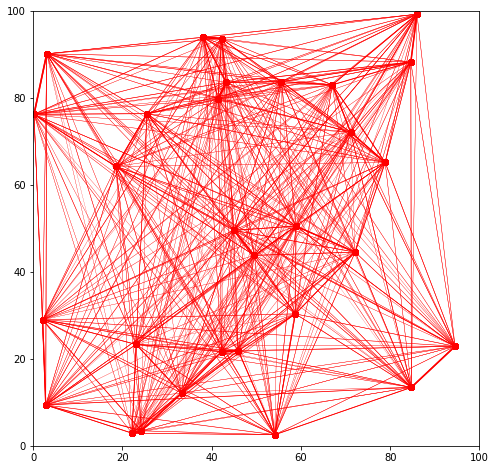

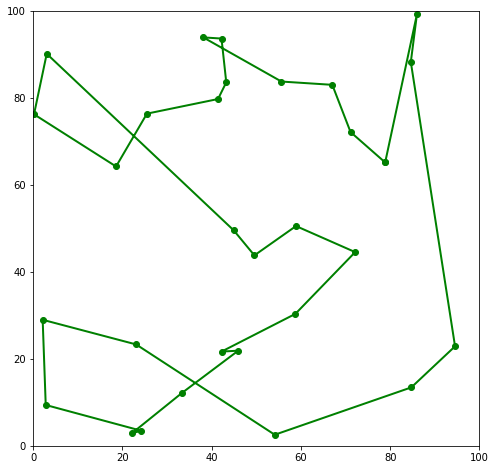

['3', '22', '24', '18', '11', '23', '5', '29', '1', '19', '6', '9', '2', '14', '27', '7', '25', '12', '16', '21', '13', '28', '4', '17', '15', '10', '0', '8', '26', '20'] 563.9483450778459


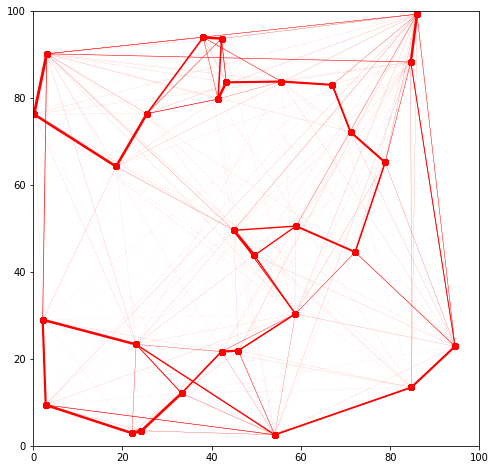

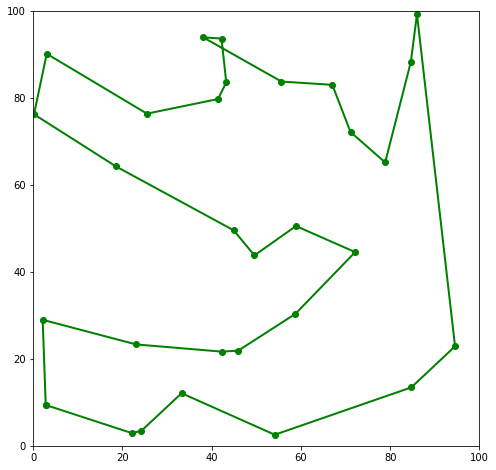

['4', '17', '15', '12', '16', '25', '7', '27', '14', '2', '19', '6', '9', '1', '29', '5', '23', '11', '18', '24', '22', '3', '26', '20', '8', '0', '10', '21', '28', '13'] 529.4653183079155


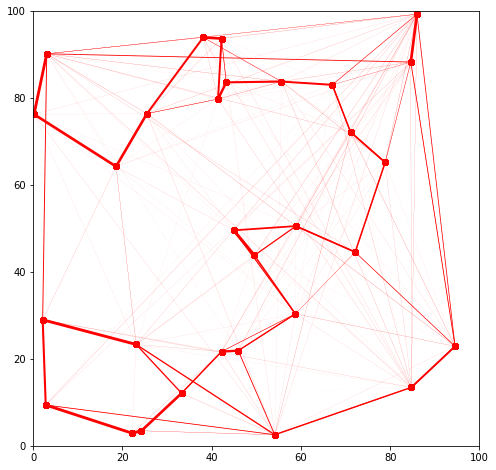

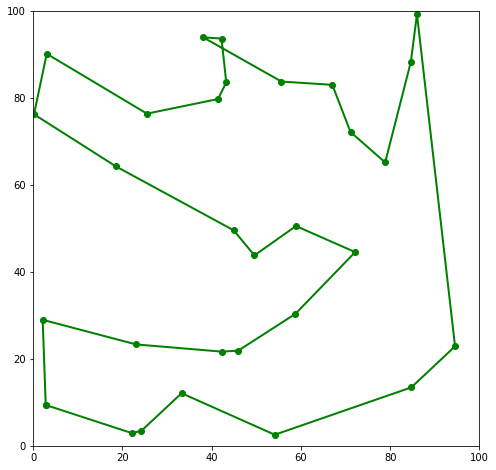

['4', '17', '15', '12', '16', '25', '7', '27', '14', '2', '19', '6', '9', '1', '29', '5', '23', '11', '18', '24', '22', '3', '26', '20', '8', '0', '10', '21', '28', '13'] 529.4653183079155


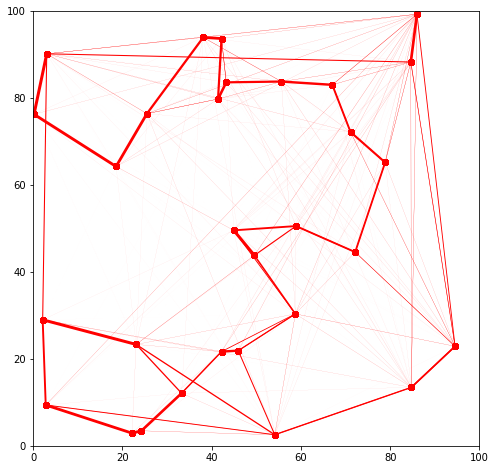

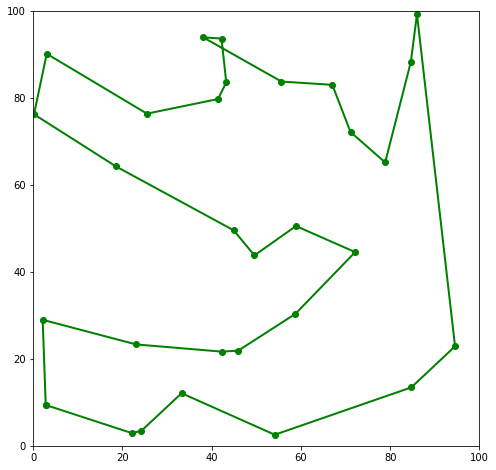

['4', '17', '15', '12', '16', '25', '7', '27', '14', '2', '19', '6', '9', '1', '29', '5', '23', '11', '18', '24', '22', '3', '26', '20', '8', '0', '10', '21', '28', '13'] 529.4653183079155


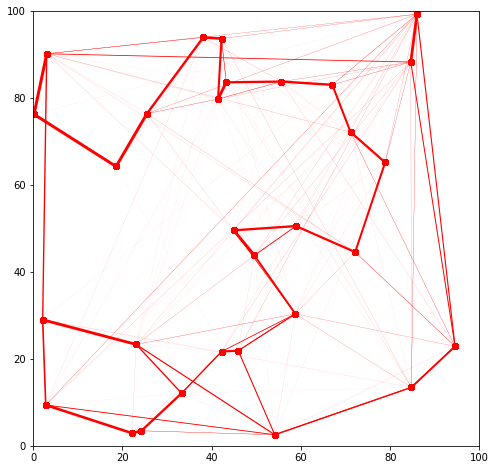

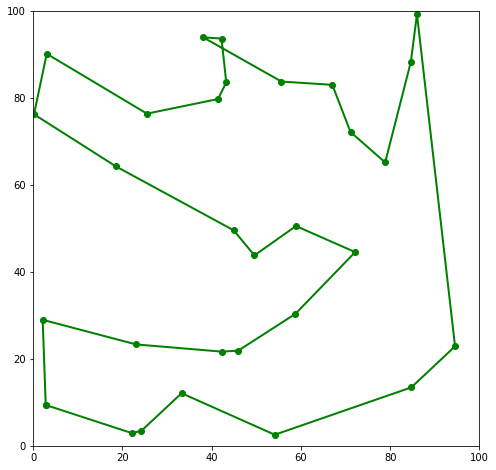

['4', '17', '15', '12', '16', '25', '7', '27', '14', '2', '19', '6', '9', '1', '29', '5', '23', '11', '18', '24', '22', '3', '26', '20', '8', '0', '10', '21', '28', '13'] 529.4653183079155


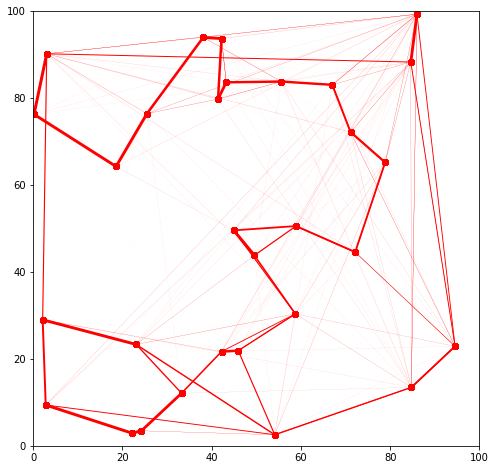

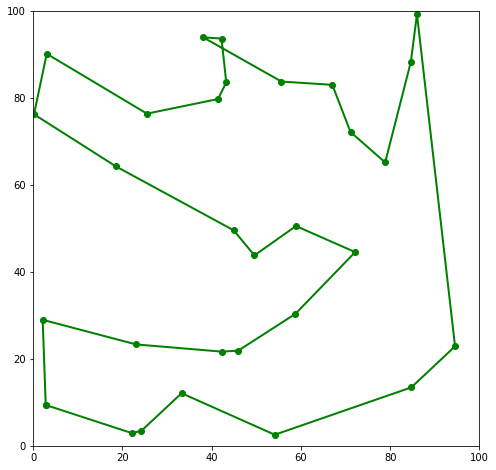

['4', '17', '15', '12', '16', '25', '7', '27', '14', '2', '19', '6', '9', '1', '29', '5', '23', '11', '18', '24', '22', '3', '26', '20', '8', '0', '10', '21', '28', '13'] 529.4653183079155


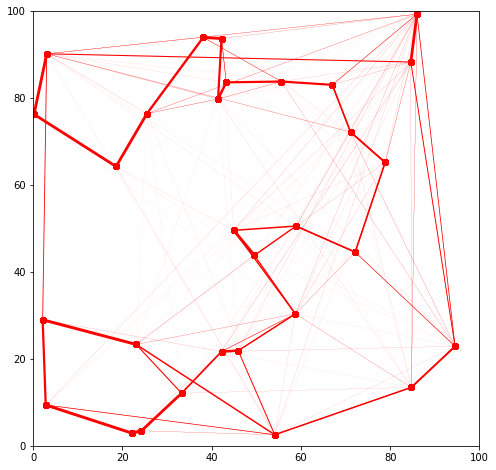

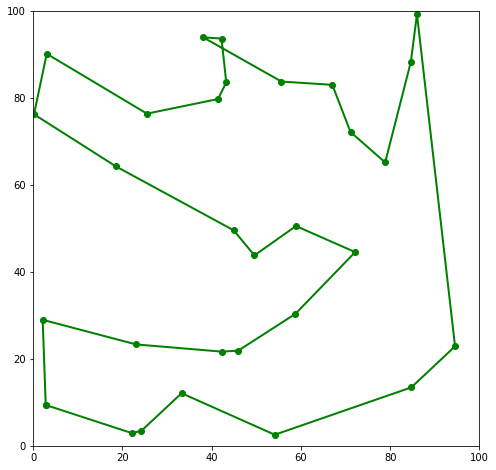

['4', '17', '15', '12', '16', '25', '7', '27', '14', '2', '19', '6', '9', '1', '29', '5', '23', '11', '18', '24', '22', '3', '26', '20', '8', '0', '10', '21', '28', '13'] 529.4653183079155


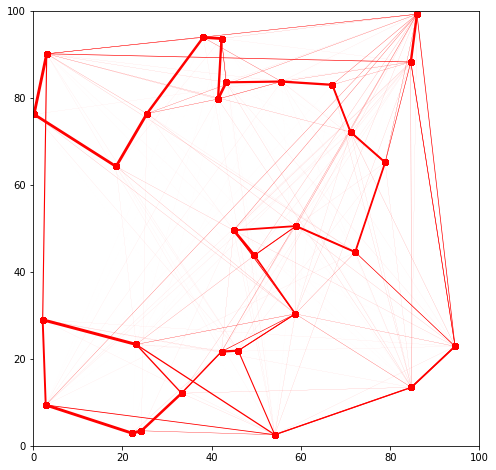

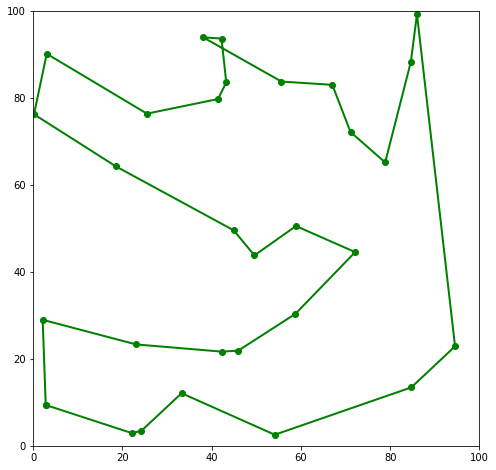

['4', '17', '15', '12', '16', '25', '7', '27', '14', '2', '19', '6', '9', '1', '29', '5', '23', '11', '18', '24', '22', '3', '26', '20', '8', '0', '10', '21', '28', '13'] 529.4653183079155


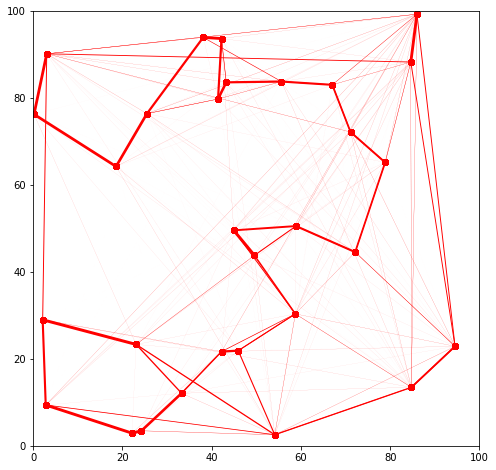

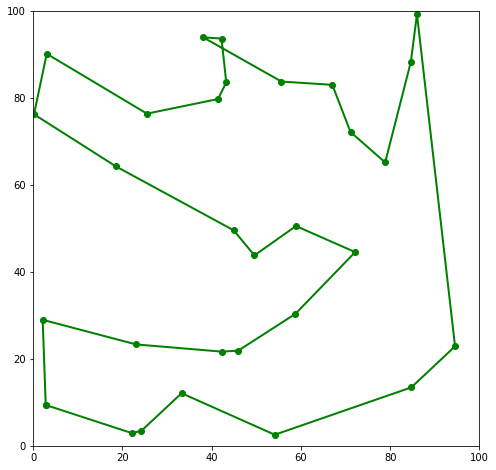

['4', '17', '15', '12', '16', '25', '7', '27', '14', '2', '19', '6', '9', '1', '29', '5', '23', '11', '18', '24', '22', '3', '26', '20', '8', '0', '10', '21', '28', '13'] 529.4653183079155


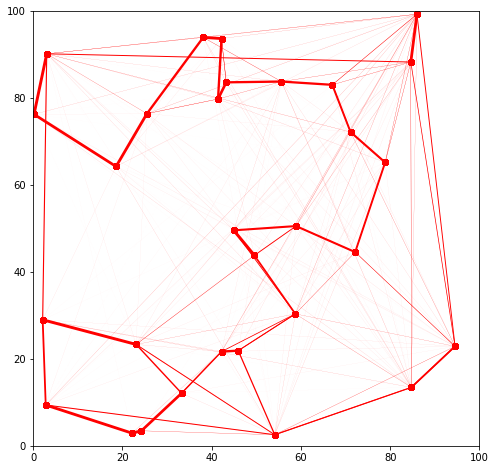

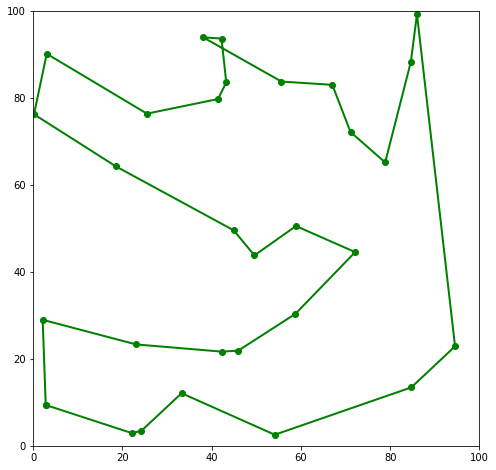

['4', '17', '15', '12', '16', '25', '7', '27', '14', '2', '19', '6', '9', '1', '29', '5', '23', '11', '18', '24', '22', '3', '26', '20', '8', '0', '10', '21', '28', '13'] 529.4653183079155


(['4',
  '17',
  '15',
  '12',
  '16',
  '25',
  '7',
  '27',
  '14',
  '2',
  '19',
  '6',
  '9',
  '1',
  '29',
  '5',
  '23',
  '11',
  '18',
  '24',
  '22',
  '3',
  '26',
  '20',
  '8',
  '0',
  '10',
  '21',
  '28',
  '13'],
 529.4653183079155)

In [90]:
# more ants make algorithm converge faster
# higher alpha increases exploitation of paths (too high alpha exploits random choices!)
# higher beta increases attention to local good (greedy) choices also increases exploration 
# (by lowering relative effect of alpha and pheromone)
# higher ro increases exploration and lowers exploitation (is less based on history)
# higher exploration to exploitation ratio delays convergence

# Heuristic knowledge shows local good choices to the ants, decreases relative effect of pheromones (lowers exploitation).
# It is not necessary but without it algorithm performs much worse 
# (probably exploration-exploitation might be balanced by alpha-ro)

# Converge speed in ACO in influenced by number of ants, alpha, beta, ro

# Obvious choices are the first to be determined as doing wrong there decreases solution quality a lot
# so there is much less pheromone, also heuristic info helps the most in choosing the obvious paths

# Algorithm searches the solution space with heuristic info and narrows its choices by pheromone accumulation
# It constructs new, better solutions by randomly picking it from narrowed space and sticks to them by further pheromone distribution adjustment

#strengths:
# ACO is good at constructing paths/series, quickly finds good solutions 
# weaknesses:
# ACO is applicable only to discrete problems, often converges prematurely, 
# takes into account only local choices when building solution, ACO is worse for high epistasis problems, 
# random start could be wrong for some problems.

# ACO modification could be to model the starting node distribution (in problems that it matters)
# also ACO solution construction could be modified to take into account global direction of ants
# instead of only focusing on local choice and its effect on local/global score

# ACO is best suited for solving path finding and graph problems.
random.seed(1)
tsp = TSPrand()

tsp.solve(iterations = 100, ants = 100, alpha = 1, beta = 5, ro = 0.8, q = 5, display_period = 10)

**Task 4:**

Implement the Knapsack problem. Use ACO to solve it.

In [130]:
import numpy as np
class Knapsack(Problem):
   #TODO implement the knapsack problem
    min_prob = False
    
    def __init__(self, size, itemSizes, itemValues):
        self.size = size
        self.itemSizes = itemSizes
        self.itemValues = itemValues
        self.num_items = len(itemSizes)
        self.parts_phero = [1 for i in range(len(itemSizes))]
        self.parts_phero_delta = [0 for i in range(len(itemSizes))]
        
    # initial solution is empty bag    
    def initial_solution(self):
        solution = np.zeros(self.num_items)
        return solution
    
    def solution_parts(self, solution):
        return np.argwhere(solution)[:,0]
    
    def solution_quality(self, solution):
        return (np.array(solution) * np.array(self.itemValues)).sum()
    
    def possible_choices(self, part_solution):
        size_left = self.size - (np.array(part_solution) * np.array(self.itemSizes)).sum()
        not_chosen_and_fit = np.where((np.array(self.itemSizes) <= size_left) & (np.array(part_solution) == 0))[0]
            
        heuristic_info = [self.itemValues[item] ** self.beta for item in not_chosen_and_fit]
        pheromone_strength = [self.parts_phero[item] ** self.alpha for item in not_chosen_and_fit]
        phero_heuristic = [pheromone_strength[i] * heuristic_info[i] for i in range(len(not_chosen_and_fit))]
        sum_phero_heuristic = sum(phero_heuristic)
        probs = [phero_heuristic[i]/sum_phero_heuristic for i in range(len(not_chosen_and_fit))]
        return not_chosen_and_fit, probs
        
    def construction_step(self, part_solution):
        #print(part_solution)
        choices, probs = self.possible_choices(part_solution)
        # TODO select and add a new element to the solution
        part_solution[random.choices(population = choices, weights = probs)] = 1
        
        return part_solution
    
knap = Knapsack(size = 20, itemSizes=np.random.rand(500),
    itemValues=np.random.rand(500) )
knap.solve(iterations = 100, ants = 10, alpha = 1, beta = 1, ro = 0.3, q = 0.1, display_period = 10)
        

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.

[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.

(array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 